In [57]:
import os
import caffe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# set the plotting parameters
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# we'll use the GoogLeNet model we fine-tuned
caffe_root = '/home/rips_tc/caffe/'
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/google_logonet/deploy.prototxt',
                caffe_root + 'models/google_logonet/logonet.caffemodel',
                caffe.TEST)
net.blobs['data'].reshape(1, 3, 224, 224)

# set the transformer to conform to ImageNet standard
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'data/logos/logos_mean_deploy.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # imagenet operates on [0,255]
transformer.set_channel_swap('data', (2,1,0))

#we'll want the labels later, so load them from text:
logo_labels = caffe_root + 'data/logos/index-brand.txt'
labels = np.loadtxt(logo_labels, str, delimiter='\t')

# return the top num_results of classification. default is num_results = 5
def top_results(image_src, num_results=3):
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(image_src))
    out = net.forward()
    plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
    top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-(num_results+1):-1]
    print labels[top_k]

# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

In [58]:
#images we'll look at
real = caffe_root + 'examples/logo_vis/example1.jpg'
digital = caffe_root + 'data/logos/images/starbucks/image_5.jpg'

#Features of Digital and Real-World Images
Here, we look at a couple of the layer outputs from GoogLeNet for a digital and real-world image of a logo of Starbucks.

['2 adidas' '104 nestle' '137 starbucks']


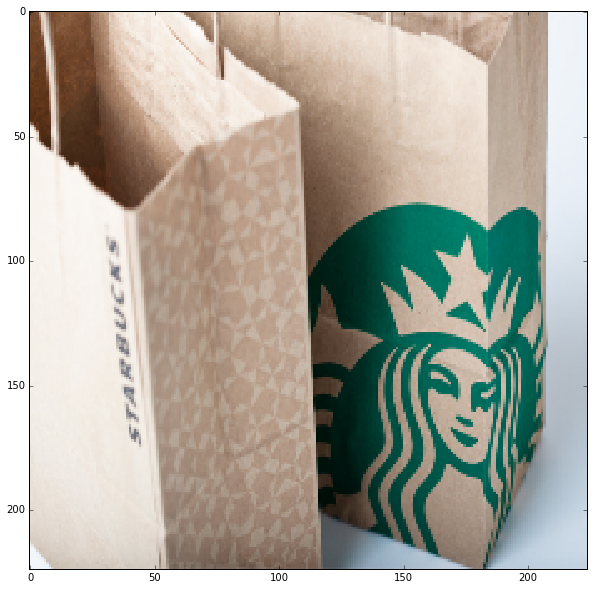

In [65]:
top_results(real)

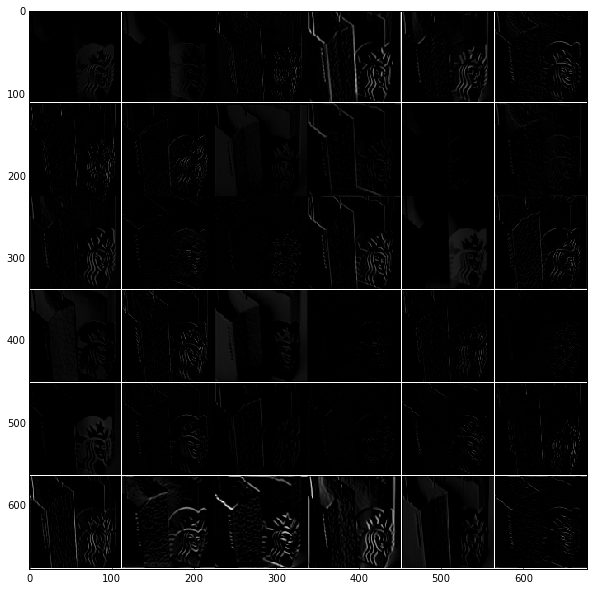

In [60]:
feat = net.blobs['conv1/7x7_s2'].data[0, :36]
vis_square(feat, padval=1)

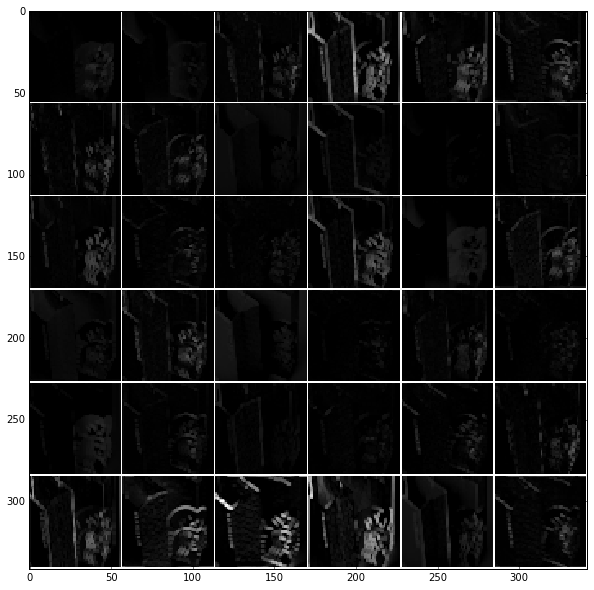

In [61]:
feat = net.blobs['pool1/3x3_s2'].data[0, :36]
vis_square(feat, padval=1)

Mostly, the features learned seem to be related to the Starbucks logo portion of the image. Now for the digital logo image.

['137 starbucks' '107 nike' '27 chineseuniversityofhongkong']


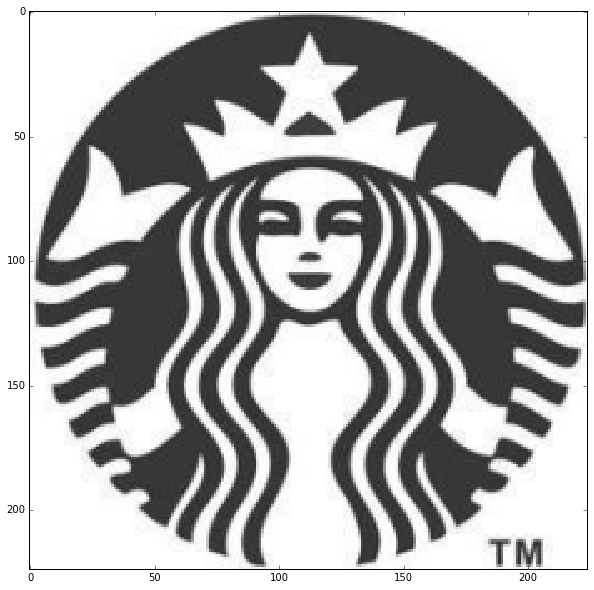

In [62]:
top_results(digital)

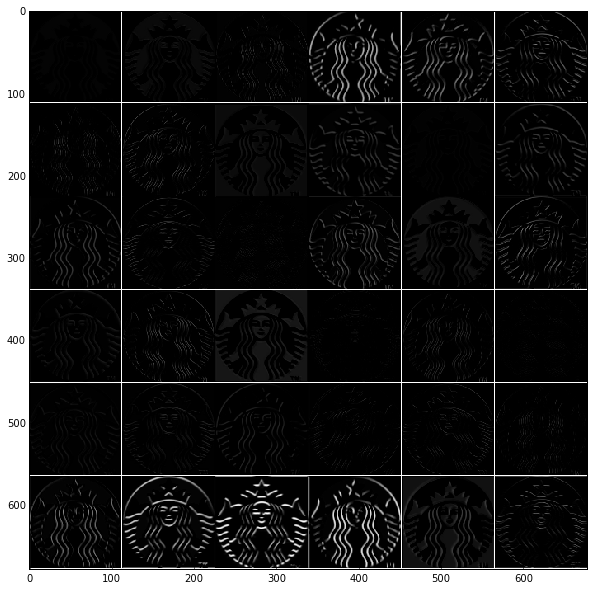

In [63]:
feat = net.blobs['conv1/7x7_s2'].data[0, :36]
vis_square(feat, padval=1)

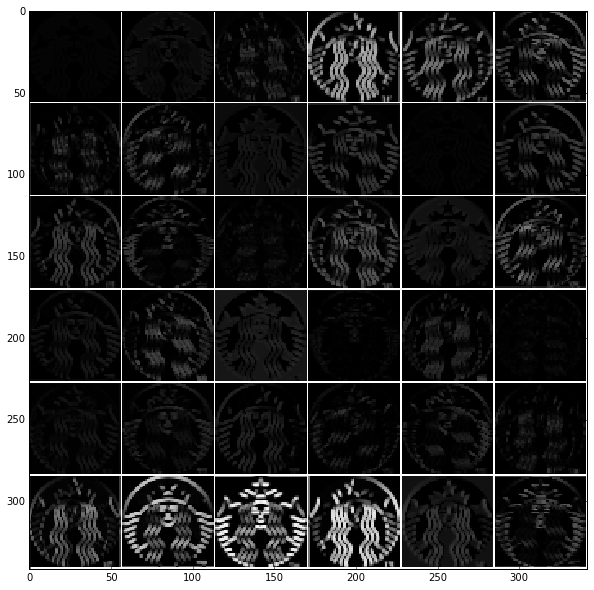

In [64]:
feat = net.blobs['pool1/3x3_s2'].data[0, :36]
vis_square(feat, padval=1)